<a href="https://colab.research.google.com/github/jeon-maker/Crowd_counting/blob/main/use_1st.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Efficientdet 사용**

In [16]:
import time
import concurrent.futures
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import PIL
from PIL.ImageDraw import Draw

In [ ]:
META_FILE = '/content/drive/MyDrive/crowd_detection/labels.csv'


In [ ]:
MODEL_PATH = 'https://tfhub.dev/tensorflow/efficientdet/d0/1'


In [ ]:
def reconstruct_path(image_id: int) -> str:
    """Function transforms numerical image ID
    into a relative file path filling in leading zeros
    and adding file extension and directory.
    :param image_id: Image ID
    :return: Relative path to the image
    """
    image_id = str(image_id).rjust(6, '0')
    return f'/content/drive/MyDrive/crowd_detection/frames/frames/seq_{image_id}.jpg'

def detect_objects(path: str, model) -> dict:
    """Function extracts image from a file, adds new axis
    and passes the image through object detection model.
    :param path: File path
    :param model: Object detection model
    :return: Model output dictionary
    """
    image_tensor = tf.image.decode_jpeg(
        tf.io.read_file(path), channels=3)[tf.newaxis, ...]
    return model(image_tensor)

def count_persons(path: str, model, threshold=0.) -> int:
    """Function counts the number of persons in an image
    processing "detection_classes" output of the model
    and taking into account confidence threshold.
    :param path: File path
    :param model: Object detection model
    :param threshold: Threshold for confidence scores
    :return: Number of people for one image
    """
    results = detect_objects(path, model)
    # Class ID 1 = "person"
    return (results['detection_classes'].numpy()[0] == 1)[np.where(
        results['detection_scores'].numpy()[0] > threshold)].sum()

def draw_bboxes(image_path, data: dict, threshold=0.) -> PIL.Image:
    """Function displays an image with bounding boxes
    overlaid for every detected person.
    :param image_path: File path to an image
    :param data: Output of objects detection model for this image
    :param threshold: Threshold for confidence scores
    :return: PIL.Image object
    """
    image = PIL.Image.open(image_path)
    draw = Draw(image)

    im_width, im_height = image.size
    boxes = data['detection_boxes'].numpy()[0]
    classes = data['detection_classes'].numpy()[0]
    scores = data['detection_scores'].numpy()[0]

    for i in range(int(data['num_detections'][0])):
        if classes[i] == 1 and scores[i] > threshold:
            ymin, xmin, ymax, xmax = boxes[i]
            (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                          ymin * im_height, ymax * im_height)
            draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
                      width=4, fill='red')

    return image

def set_display():
    """Function sets display options for charts and pd.DataFrames.
    """
    # Plots display settings
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = 12, 8
    plt.rcParams.update({'font.size': 14})
    # DataFrame display settings
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.options.display.float_format = '{:.4f}'.format

In [ ]:
set_display()


In [ ]:
# Input data
data = pd.read_csv(META_FILE)
data['path'] = data['id'].apply(reconstruct_path)
data.head()

,id,count,path
0,1,35,/content/drive/MyDrive/crowd_detection/frames/...
1,2,41,/content/drive/MyDrive/crowd_detection/frames/...
2,3,41,/content/drive/MyDrive/crowd_detection/frames/...
3,4,44,/content/drive/MyDrive/crowd_detection/frames/...
4,5,41,/content/drive/MyDrive/crowd_detection/frames/...


In [ ]:
stats = data.describe()
stats

,id,count
count,2000.0000,2000.0000
mean,1000.5000,31.1575
std,577.4946,6.9454
min,1.0000,13.0000
25%,500.7500,26.0000
50%,1000.5000,31.0000
75%,1500.2500,36.0000
max,2000.0000,53.0000


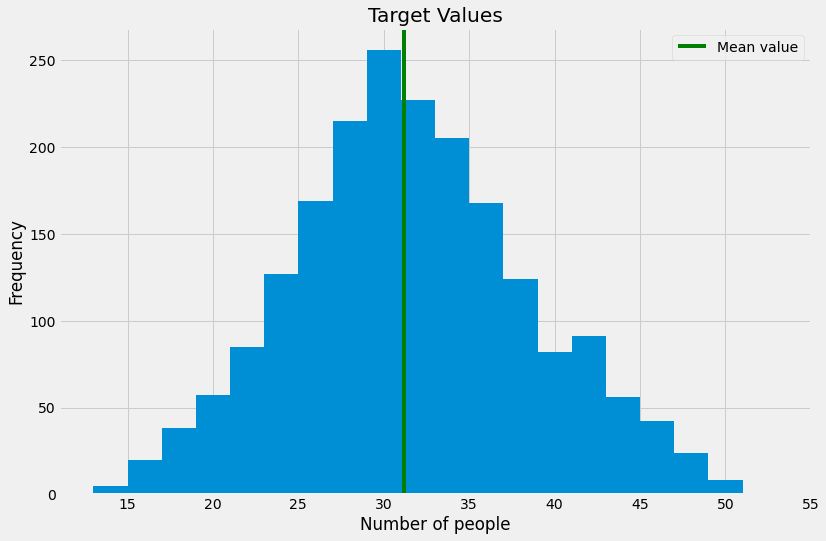

In [ ]:
plt.hist(data['count'], bins=20)
plt.axvline(stats.loc['mean', 'count'], label='Mean value', color='green')
plt.legend()
plt.xlabel('Number of people')
plt.ylabel('Frequency')
plt.title('Target Values')
plt.show()

In [ ]:
detector = hub.load(MODEL_PATH)


In [ ]:
detector

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f27e4d0fe50>

In [ ]:
def detect_objects2(path: str, model) -> dict:
    """Function extracts image from a file, adds new axis
    and passes the image through object detection model.
    :param path: File path
    :param model: Object detection model
    :return: Model output dictionary
    """
    image_tensor = tf.image.decode_jpeg(
        tf.io.read_file(path), channels=3)[tf.newaxis, ...]
    return(image_tensor)

In [ ]:
# Object detection with no confidence threshold results in
# duplicate bounding boxes and false positives.
# Total number of people in an image is overestimated.
# Some mannequins are erroneously marked as people.
example_path = '/content/drive/MyDrive/crowd_detection/frames/frames/seq_000010.jpg'
results = detect_objects2(example_path, detector)


In [ ]:
results

<tf.Tensor: shape=(1, 480, 640, 3), dtype=uint8, numpy=
array([[[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        ...,

        [[150, 127, 109],
         [150, 127, 109],
         [149, 126, 108],
         ...,
         [196, 161, 129],
         [200, 166, 131],
         [201, 167, 130]],

        [[148, 125, 107],
         [147, 124, 106],
         [146, 123, 105],
         ...,
         [184, 149, 117],
         [187, 153, 118],
         [189, 155, 120]],

        [[148, 125, 107],
         [147, 124, 106],
         [146, 123

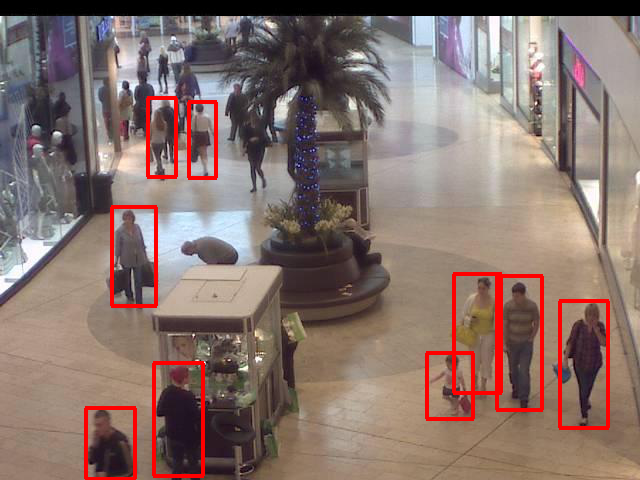

In [ ]:
draw_bboxes(example_path, results, threshold=0.5)


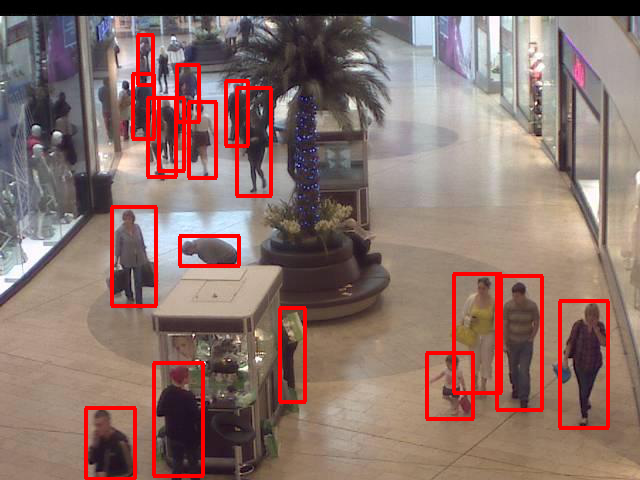

In [ ]:
draw_bboxes(example_path, results, threshold=0.25)


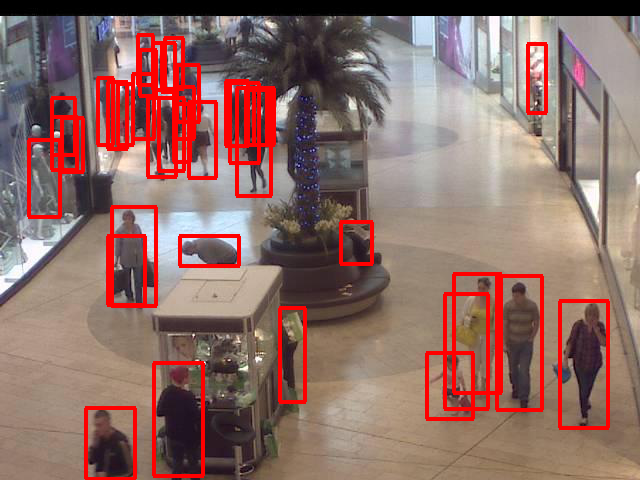

In [ ]:
draw_bboxes(example_path, results, threshold=0.125)


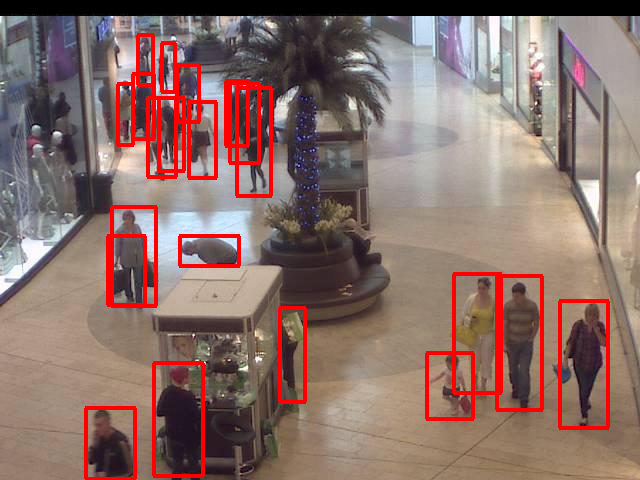

In [ ]:
draw_bboxes(example_path, results, threshold=0.2)


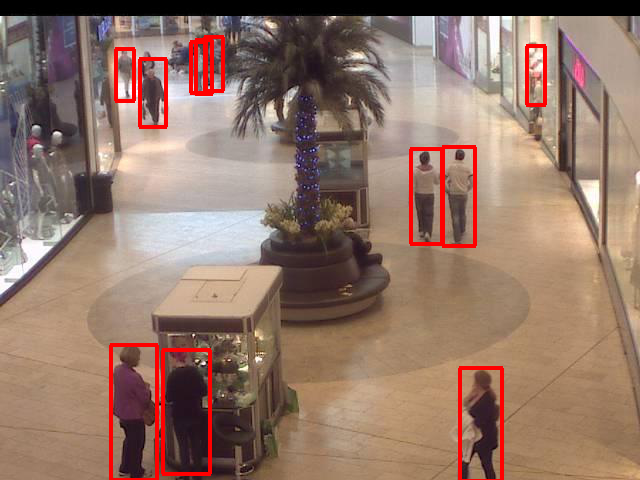

In [17]:
example_path = data.loc[data['count'] == data['count'].min(), 'path'].iloc[0]
results = detect_objects(example_path, detector)
draw_bboxes(example_path, results, threshold=0.25)

In [18]:
results

{'detection_anchor_indices': <tf.Tensor: shape=(1, 100), dtype=float32, numpy=
 array([[11357., 42684., 11329., 24056., 23786.,  5326.,  4146., 47277.,
         46726., 25188.,  3642.,  3633., 24967., 11040., 24621., 26340.,
         25539., 39881., 24630.,  4515.,  3651., 10428.,  3039., 23157.,
         11022.,  3048., 21516., 12393., 23172., 25773., 22588., 26688.,
         23181., 42146., 24030., 42434., 42149., 23154., 24333.,  2499.,
         11013., 22011.,  3012., 25189., 10410., 40455.,  4782., 46644.,
         22092., 25190., 25188.,  4714., 20922., 25566., 22020., 12371.,
          6819., 19770., 12349., 26142., 25008., 21525., 24408., 25503.,
         23289., 22722., 12971.,  4155., 26122.,  3030., 24618., 24054.,
         14725.,  6378., 22581., 19788.,  3084., 24918., 20949., 26352.,
         22713.,  5280., 23814., 25517.,  4164., 10779., 26340., 22722.,
          4782., 38147., 24039., 19761., 25185., 22731.,  2490., 25503.,
          2481., 21507., 22893.,  3561.]], dt

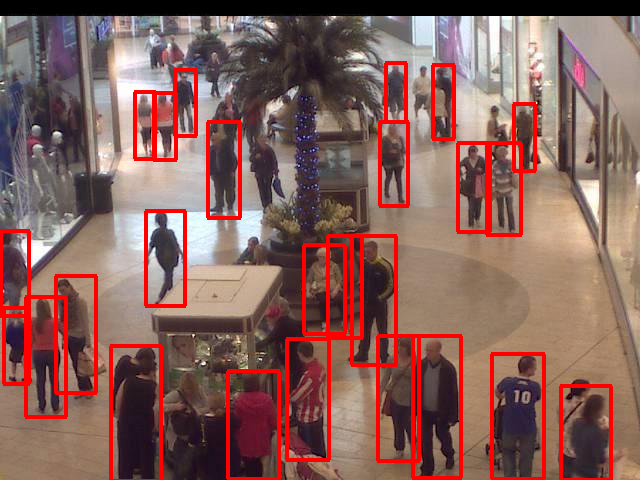

In [19]:
example_path = data.loc[data['count'] == data['count'].max(), 'path'].iloc[0]
results = detect_objects(example_path, detector)
draw_bboxes(example_path, results, threshold=0.25)

In [20]:
data['path'] = data['id'].apply(reconstruct_path)


In [22]:
def load_image(is_labelled: bool, is_training=True):
    """Wrapper function that returns a function
    for loading a single image if is_labelled=False
    or a function for loading image in an image-label pair
    if is_labelled=True.
    :param is_labelled: Boolean argument defining the return
    :param is_training: Boolean argument for image augmentation
    :return: Function
    """
    def _get_image(path: str) -> tf.Tensor:
        """Function loads image from a file.
        :param path: Path to image file
        :return: Tensor with preprocessed image
        """
        image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
        image = tf.cast(image, dtype=tf.int32)
        image = tf.image.resize_with_pad(image, IMAGE_SIZE, IMAGE_SIZE)
        if is_training:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, 0.1)
            image = tf.image.random_contrast(image, 0.1, 0.2)
            image = tf.image.random_saturation(image, 0.9, 1.1)
            image = tf.image.random_hue(image, 0.1)
        return tf.keras.applications.inception_resnet_v2.preprocess_input(image)

    def _get_image_label(img: tf.Tensor, label: int) -> tuple:
        """Function loads the image in an image-label pair.
        :param img: Tensor with original image
        :param label: Target value
        :return: Tuple with TF tensor and label
        """
        return _get_image(img), label

    return _get_image_label if is_labelled else _get_image
def prepare_dataset(dataset, is_training=True, is_labeled=True):
    """Function transforms a TF dataset containing file paths
    or file paths and labels to a dataset with image tensors and labels.
    :param dataset: Original dataset
    :param is_training: Argument defines if shuffling and image augmentation should be applied
    :param is_labeled: Argument defines if the dataset contains labels
    :return: Updated dataset
    """
    image_read_fn = load_image(is_labeled, is_training)
    dataset = dataset.map(image_read_fn, num_parallel_calls=AUTOTUNE)
    return dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

def create_model() -> tf.keras.Model:
    """Function initializes and compiles a regression model
    with pretrained feature extractor.
    :return: TF Model object
    """
    feature_model = tf.keras.applications.InceptionResNetV2(
        include_top=False, pooling='avg')
    feature_model.trainable = False

    model = tf.keras.Sequential([
        tf.keras.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        feature_model,
        tf.keras.layers.Dense(512, activation='selu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model

def plot_history(hist):
    """Function plots a chart with training and validation metrics.
    :param hist: Tensorflow history object from model.fit()
    """
    mae = hist.history['mean_absolute_error']
    val_mae = hist.history['val_mean_absolute_error']
    x_axis = range(1, len(mae) + 1)
    plt.plot(x_axis, mae, 'bo', label='Training')
    plt.plot(x_axis, val_mae, 'ro', label='Validation')
    plt.title('MAE')
    plt.legend()
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.show()

def set_seed(seed=42):
    """Utility function to use for reproducibility.
    :param seed: Random seed
    :return: None
    """
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [24]:
# TensorFlow settings and training parameters
AUTOTUNE = tf.data.experimental.AUTOTUNE
EPOCHS = 100
BATCH_SIZE = 16
PATIENCE = 10
LEARNING_RATE = 1e-3
IMAGE_SIZE = 299

In [25]:
# Create train and validation data sets.
data_train = data.head(1700)
data_valid = data.tail(300)

ds_train = tf.data.Dataset.from_tensor_slices((data_train['path'], data_train['count'])) #이미지와 실제 카운트를 훈련시킴
ds_valid = tf.data.Dataset.from_tensor_slices((data_valid['path'], data_valid['count'])) #검증모델

ds_train = prepare_dataset(ds_train)
ds_valid = prepare_dataset(ds_valid, is_training=False)

In [34]:
sample = data.sample(frac=0.1) #무작위 추출
start = time.perf_counter()
objects = []
#data 는 label.csv
#path는 image

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(count_persons, path, detector, 0.1625) for path in data_valid['path']]
    for f in tqdm(concurrent.futures.as_completed(results)):
        objects.append(f.result())

finish = time.perf_counter()
print(f'Finished in {round(finish - start, 2)} second(s).')

300it [03:07,  1.60it/s]

Finished in 188.07 second(s).


In [35]:
# Compare predicted values with the ground truth.
data_valid['prediction'] = objects
data_valid.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,count,path,prediction
1700,1701,31,/content/drive/MyDrive/crowd_detection/frames/...,36
1701,1702,29,/content/drive/MyDrive/crowd_detection/frames/...,42
1702,1703,36,/content/drive/MyDrive/crowd_detection/frames/...,32
1703,1704,35,/content/drive/MyDrive/crowd_detection/frames/...,37
1704,1705,37,/content/drive/MyDrive/crowd_detection/frames/...,41
1705,1706,30,/content/drive/MyDrive/crowd_detection/frames/...,34
1706,1707,32,/content/drive/MyDrive/crowd_detection/frames/...,34
1707,1708,33,/content/drive/MyDrive/crowd_detection/frames/...,32
1708,1709,37,/content/drive/MyDrive/crowd_detection/frames/...,44
1709,1710,37,/content/drive/MyDrive/crowd_detection/frames/...,38


In [36]:
data_valid['miss'] = abs(data_valid['prediction']-data_valid['count'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
data_valid

,id,count,path,prediction,miss
1700,1701,31,/content/drive/MyDrive/crowd_detection/frames/...,36,5
1701,1702,29,/content/drive/MyDrive/crowd_detection/frames/...,42,13
1702,1703,36,/content/drive/MyDrive/crowd_detection/frames/...,32,4
1703,1704,35,/content/drive/MyDrive/crowd_detection/frames/...,37,2
1704,1705,37,/content/drive/MyDrive/crowd_detection/frames/...,41,4
1705,1706,30,/content/drive/MyDrive/crowd_detection/frames/...,34,4
1706,1707,32,/content/drive/MyDrive/crowd_detection/frames/...,34,2
1707,1708,33,/content/drive/MyDrive/crowd_detection/frames/...,32,1
1708,1709,37,/content/drive/MyDrive/crowd_detection/frames/...,44,7
1709,1710,37,/content/drive/MyDrive/crowd_detection/frames/...,38,1


In [39]:
data_valid['miss'].mean()

5.266666666666667

In [40]:
data_valid['miss'].max()

19

In [41]:
data_valid[data_valid['miss']==19]

,id,count,path,prediction,miss
1933,1934,25,/content/drive/MyDrive/crowd_detection/frames/...,44,19


In [42]:
for i in range(20):
    correct = len(data_valid[data_valid['miss']==i])
    accuracy = (int(correct)/300)*100
    print("miss : %d 의 비율은 %f 퍼센트 입니다" %(i,accuracy))  

miss : 0 의 비율은 9.333333 퍼센트 입니다
miss : 1 의 비율은 11.666667 퍼센트 입니다
miss : 2 의 비율은 9.000000 퍼센트 입니다
miss : 3 의 비율은 11.333333 퍼센트 입니다
miss : 4 의 비율은 11.666667 퍼센트 입니다
miss : 5 의 비율은 8.000000 퍼센트 입니다
miss : 6 의 비율은 6.666667 퍼센트 입니다
miss : 7 의 비율은 5.666667 퍼센트 입니다
miss : 8 의 비율은 6.333333 퍼센트 입니다
miss : 9 의 비율은 3.333333 퍼센트 입니다
miss : 10 의 비율은 4.333333 퍼센트 입니다
miss : 11 의 비율은 3.333333 퍼센트 입니다
miss : 12 의 비율은 2.666667 퍼센트 입니다
miss : 13 의 비율은 0.666667 퍼센트 입니다
miss : 14 의 비율은 1.333333 퍼센트 입니다
miss : 15 의 비율은 1.000000 퍼센트 입니다
miss : 16 의 비율은 2.000000 퍼센트 입니다
miss : 17 의 비율은 0.666667 퍼센트 입니다
miss : 18 의 비율은 0.666667 퍼센트 입니다
miss : 19 의 비율은 0.333333 퍼센트 입니다


In [43]:
sum = 0
for i in range(6):
    correct = len(data_valid[data_valid['miss']==i])
    accuracy = (int(correct)/300)*100
    sum += accuracy
print(sum)    

60.99999999999999


MAE = 6.065
MSE = 61.555


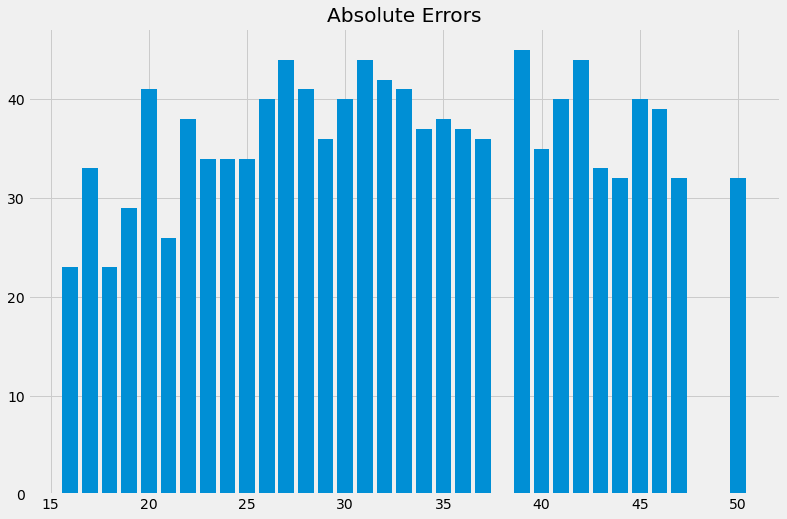

In [29]:
sample['mae'] = (sample['count'] - sample['prediction']).abs()
sample['mse'] = sample['mae'] ** 2

print(f'MAE = {sample["mae"].mean()}\nMSE = {sample["mse"].mean()}')
plt.bar(sample['count'],sample['prediction'])
plt.title('Absolute Errors')
plt.show()

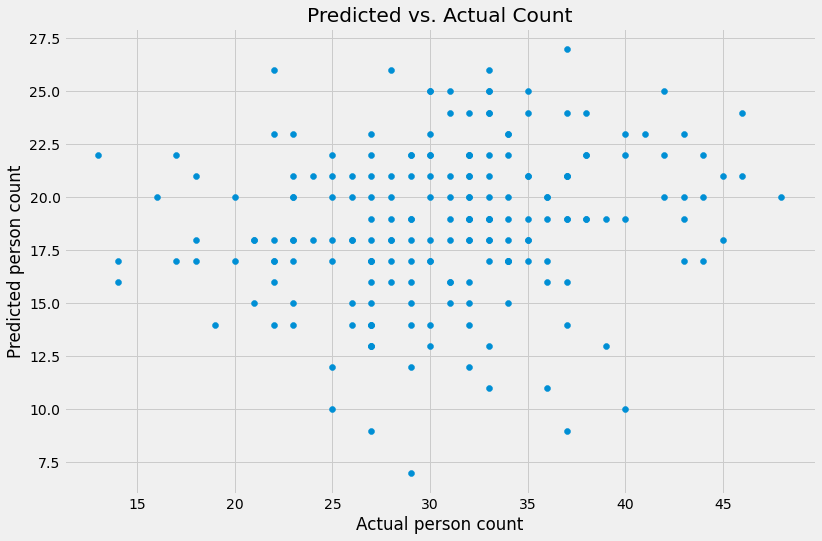

In [ ]:
plt.scatter(sample['count'], sample['prediction'])
plt.xlabel('Actual person count')
plt.ylabel('Predicted person count')
plt.title('Predicted vs. Actual Count')
plt.show()

In [ ]:
sample['mae'] = (sample['count'] - sample['prediction']).abs()
miss = sample['mae']

In [ ]:
len(sample)

200

In [ ]:
miss.mean()

12.29

In [ ]:
len(miss)

200